# K-Means Clustering Project - Apra Data Science Challenge 2025

In this exercise, we'll be using the K-Means Clustering algorithm to segment over 500,000 sample fundraising constituents into natural groupings. **K-Means** is a method of segmenting a dataset in which each data point is placed into one of *K* clusters so that each observation belongs to the cluster with the nearest *centroid*, i.e. the mean of the cluster. In practice, this means that the data points within each cluster are most similar to each other, and less similar to data points in the other clusters. Let's get started on our exercise:

## 1. Data Preparation

We'll begin by importing the requisite libraries:

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import mplcursors
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.decomposition import PCA
import numpy as np

# Default to centering matplotlib within the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import pyodbc
import warnings
import joblib

warnings.filterwarnings("ignore")

And then by connecting to the local "Philanthropy" SQL Server database:

In [3]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

Let's query our "Consituents" SQL view and turn the results into a DataFrame - this will contain a full dataset of participation information on each person in the 2025 dataset.

In [4]:
sql = """
SELECT 
[CONSTITUENT_ID],
[MANAGED_PROSPECT],
[LIFETIME_GIVING],
[Donor],
[Major Donor],
[LIFETIME_GIFT_COUNT],
[FIRST_GIFT_DATE],
[LAST_GIFT_DATE],
[Years of Giving],

[LIFETIME_CRM_INTERACTIONS],
[Lifetime Visits],
[Lifetime Phone Calls],
[Lifetime Correspondences],
[Interactions L5Y],
[Visits L5Y],
[Phone Calls L5Y],
[Correspondences L5Y],
[Interactions Prior to First Gift],
[Visits Prior to First Gift],
[Phone Calls Prior to First Gift],
[Correspondences Prior to First Gift],

[Lifetime Video Emails Opened],
[Lifetime Video Emails Clicked],
[Lifetime Video Views],
[Lifetime Videos Started],
[Lifetime Videos Watched 25 Percent],
[Lifetime Videos Watched 50 Percent],
[Lifetime Videos Watched 75 Percent],
[Lifetime Videos Finished],
[Lifetime Video Shares to Facebook],

[L5Y Video Emails Opened],
[L5Y Video Emails Clicked],
[L5Y Video Views],
[L5Y Videos Started],
[L5Y Videos Watched 25 Percent],
[L5Y Videos Watched 50 Percent],
[L5Y Videos Watched 75 Percent],
[L5Y Videos Finished],
[L5Y Video Shares to Facebook],

[Before First Gift Video Emails Opened],
[Before First Gift Video Emails Clicked],
[Before First Gift Video Views],
[Before First Gift Videos Started],
[Before First Gift Videos Watched 25 Percent],
[Before First Gift Videos Watched 50 Percent],
[Before First Gift Videos Watched 75 Percent],
[Before First Gift Videos Finished],
[Before First Gift Video Shares to Facebook],

----- COMBINED CRM + VIDEO EMAILS
[LIFETIME_CRM_INTERACTIONS] + [Lifetime Video Views] + [Lifetime Video Shares to Facebook] AS "Lifetime Combined Interaction",
[Interactions L5Y] + [L5Y Video Views] + [L5Y Video Shares to Facebook] AS "L5Y Combined Interaction",
[Interactions Prior to First Gift] + [Before First Gift Video Views] + [Before First Gift Video Shares to Facebook] AS "Before First Gift Combined Interaction",

[FIRST_CRM_INTERACTION_DATE],
[LAST_CRM_INTERACTION_DATE],
[CAPACITY_ESTIMATE],
[CAPACITY_ESTIMATE_CLEAN],
[LIFETIME_GIVING_BAND],
[LIFETIME_GIVING_BAND_LOW],
[FIVE_YEAR_GIVING_BAND],
[FIVE_YEAR_GIVING_BAND_LOW],
[R_Score],
[F_Score],
[M_Score],
[RFM_Score_Sum],
[RFM_Segment]
FROM [Philanthropy].[Apra].[ConstituentsView]
WHERE
[Interactions L5Y] + [L5Y Video Views] + [L5Y Video Shares to Facebook] >= 1
"""
df = pd.read_sql(sql,conn)

Let's replace any NULL values in the dataset with "0", and then take a quick peek at the data:

In [5]:
df = df.fillna(0)
df.head()

,CONSTITUENT_ID,MANAGED_PROSPECT,LIFETIME_GIVING,Donor,Major Donor,LIFETIME_GIFT_COUNT,FIRST_GIFT_DATE,LAST_GIFT_DATE,Years of Giving,LIFETIME_CRM_INTERACTIONS,...,CAPACITY_ESTIMATE_CLEAN,LIFETIME_GIVING_BAND,LIFETIME_GIVING_BAND_LOW,FIVE_YEAR_GIVING_BAND,FIVE_YEAR_GIVING_BAND_LOW,R_Score,F_Score,M_Score,RFM_Score_Sum,RFM_Segment
0,100730182,0,0.0,0,0,0,NA,NA,1,0,...,0,None,0,None,0,0,0,0,0,Non-Donor
1,105193921,0,0.0,0,0,0,NA,NA,1,0,...,0,None,0,None,0,0,0,0,0,Non-Donor
2,105550875,0,2000.0,1,0,1,9/28/2023,9/28/2023,1,5,...,0,"$1,000-$9,999",1000,"$1,000-$9,999",1000,5,1,5,11,Recent Donors
3,105941461,0,200.0,1,0,2,5/4/2021,9/29/2021,1,5,...,0,$1-$999,1,$1-$999,1,4,3,4,11,Recent Donors
4,107444925,0,1745.0,1,0,37,2/17/1978,11/9/2023,46,12,...,0,"$1,000-$9,999",1000,$1-$999,1,5,5,5,15,Champions


Let's split off some smaller groupings of variables that we can use for analysis:

In [6]:
# Set separate variable groupings
lifetime_vars = ['LIFETIME_CRM_INTERACTIONS','Lifetime Visits','Lifetime Phone Calls','Lifetime Correspondences','Lifetime Video Emails Opened','Lifetime Video Emails Clicked','Lifetime Video Views','Lifetime Videos Started','Lifetime Videos Watched 25 Percent','Lifetime Videos Watched 50 Percent','Lifetime Videos Watched 75 Percent','Lifetime Videos Finished','Lifetime Video Shares to Facebook','Lifetime Combined Interaction']
l5y_vars = ['Interactions L5Y','Visits L5Y','Phone Calls L5Y','Correspondences L5Y','L5Y Video Emails Opened','L5Y Video Emails Clicked','L5Y Video Views','L5Y Videos Started','L5Y Videos Watched 25 Percent','L5Y Videos Watched 50 Percent','L5Y Videos Watched 75 Percent','L5Y Videos Finished','L5Y Video Shares to Facebook','L5Y Combined Interaction']
first_gift_vars = ['Interactions Prior to First Gift','Visits Prior to First Gift','Phone Calls Prior to First Gift','Correspondences Prior to First Gift','Before First Gift Video Emails Opened','Before First Gift Video Emails Clicked','Before First Gift Video Views','Before First Gift Videos Started','Before First Gift Videos Watched 25 Percent','Before First Gift Videos Watched 50 Percent','Before First Gift Videos Watched 75 Percent','Before First Gift Videos Finished','Before First Gift Video Shares to Facebook','Before First Gift Combined Interaction']
target = ['Donor']
other = ['CAPACITY_ESTIMATE_CLEAN']
ID = ['CONSTITUENT_ID']

There's another step we'll have to do - we are going to need to normalize the rest of the numerical variables in the dataset. This step is doubly important since K-Means is a distance-based algorithm - not doing so would result in variables with different scalings being weighted differently within the model (a variable with a larger scaling - 100 to 1000, for example - would be weighted higher than a variable with a smaller scaling like 0 to 10).

Let's pull out our numerical variables, normalize them, then impute them back into the DataFrame:

In [7]:
# Set variables for normalization
var_norms = target + lifetime_vars + l5y_vars + first_gift_vars + other

# Normalize
features_norm = preprocessing.normalize(df[var_norms])
features_norm = pd.DataFrame(features_norm, columns=df[var_norms].columns)
features_norm = pd.concat([df[df.columns.difference(features_norm.columns)], features_norm], axis=1)

features_norm[var_norms]

,CAPACITY_ESTIMATE,CONSTITUENT_ID,FIRST_CRM_INTERACTION_DATE,FIRST_GIFT_DATE,FIVE_YEAR_GIVING_BAND,FIVE_YEAR_GIVING_BAND_LOW,F_Score,LAST_CRM_INTERACTION_DATE,LAST_GIFT_DATE,LIFETIME_GIFT_COUNT,...,Before First Gift Video Emails Clicked,Before First Gift Video Views,Before First Gift Videos Started,Before First Gift Videos Watched 25 Percent,Before First Gift Videos Watched 50 Percent,Before First Gift Videos Watched 75 Percent,Before First Gift Videos Finished,Before First Gift Video Shares to Facebook,Before First Gift Combined Interaction,CAPACITY_ESTIMATE_CLEAN
0,NA,100730182,0,NA,None,0,0,0,NA,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA,105193921,0,NA,None,0,0,0,NA,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA,105550875,2023-03-13,9/28/2023,"$1,000-$9,999",1000,1,2024-12-17,9/28/2023,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA,105941461,2021-06-07,5/4/2021,$1-$999,1,3,2024-05-28,9/29/2021,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA,107444925,2021-04-01,2/17/1978,$1-$999,1,5,2024-12-19,11/9/2023,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's set our final variables that we will use for the cluster model:

In [9]:
vars_final = ['Correspondences Prior to First Gift','Before First Gift Video Emails Clicked','Before First Gift Video Views','CAPACITY_ESTIMATE_CLEAN']

## 2. Principal Component Analysis

One thing we can do at this stage is to apply **Principal Components Analysis** (referred to as **"PCA"**) to the dataset. PCA is used for dimensionality reduction, which is a way to reduce the number of features used in a model while still maintaining the most important information. The way PCA does this is by identifying *n* number of *principal components* that capture most of the variation in the provided data, and then projecting the data onto those components. This also involves calculating the *explained variance*, which is the proportion of how much variation in a dataset is explained by each component.

(Credit to this great article for my understanding of PCA and explained variance: https://vitalflux.com/pca-explained-variance-concept-python-example/)

In [10]:
# Fit PCA and print the variance
pca = PCA()
pca.fit(features_norm[vars_final])
pca.explained_variance_ratio_

array([0.92979228, 0.03596835, 0.03248976, 0.0017496 ])

Let's see how it looks on the graph:

Text(0, 0.5, 'Variance')

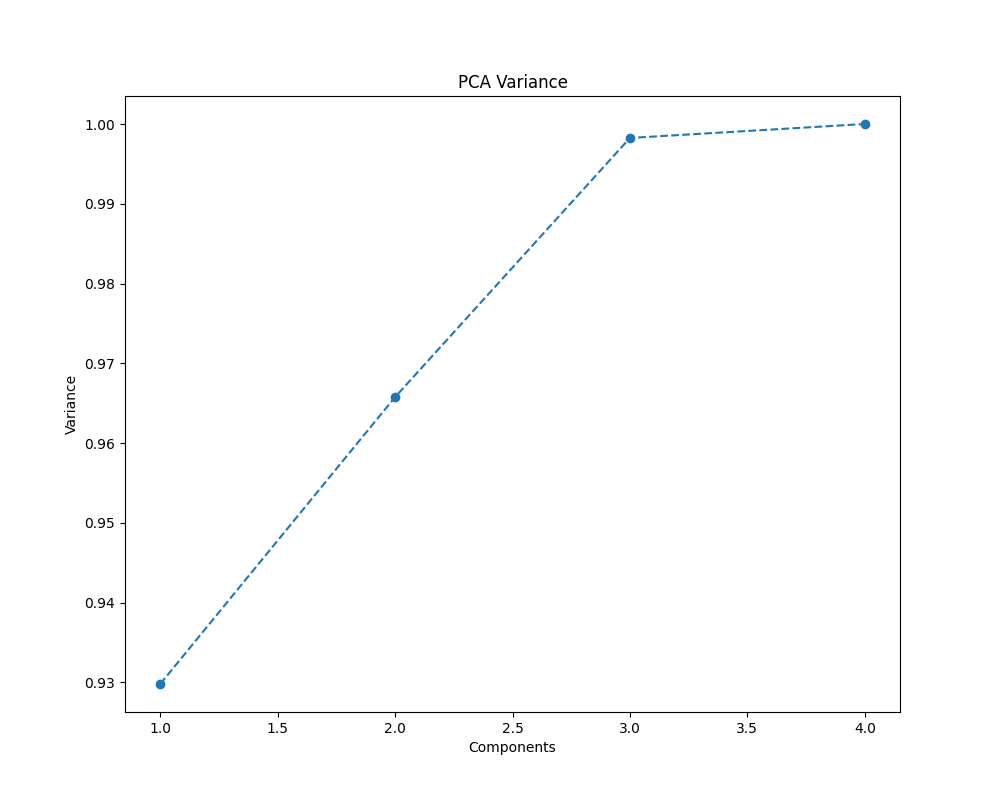

In [11]:
%matplotlib ipympl

# Plot the variance
plt.figure(figsize = (10,8))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('PCA Variance')
plt.xlabel('Components')
plt.ylabel('Variance')

Looks like **2 components** is the sweet spot where we are still explaining almost all the variance, but with a graph-able amount of features. Let's fit the PCA instance again using just two components:

In [12]:
# Fit PCA with two components
pca = PCA(n_components = 2)
pca.fit(features_norm[vars_final])
features_pca = pca.transform(features_norm[vars_final])
print(features_pca)

[[-0.0413118  -0.00999352]
 [-0.0413118  -0.00999352]
 [-0.0413118  -0.00999352]
 ...
 [-0.0413118  -0.00999352]
 [-0.0413118  -0.00999352]
 [-0.0413118  -0.00999352]]


And let's get those components back into the original dataframe:

In [13]:
df = pd.concat([df, pd.DataFrame(features_pca,columns=['Component1','Component2'])], axis=1)

## 3. Silhouettes and Elbows

Now that we've reduced our features down to just a handful of components, we need to identify the ideal number of clusters for our dataset as in K-Means we don't know in advance how many clusters to use. Luckily, there are a few methods we can use to figure that out - the **Elbow Method**, and the **Silhouette Method**.

Let's start with the **Elbow Method**, which works by plotting the explained variance of the model vs. the number of *k* clusters, and then finding the *elbow* of the curve as the number of clusters to use.

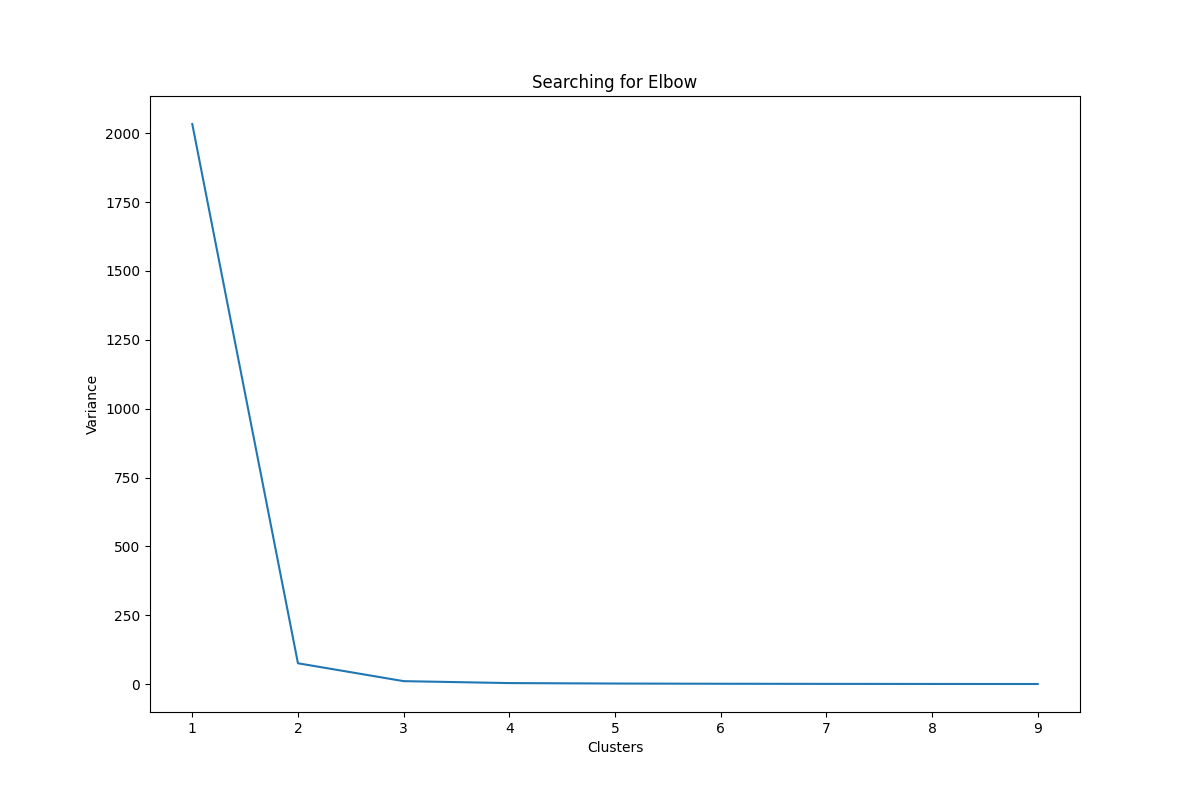

In [14]:
%matplotlib ipympl

# Find elbow bend
clusters = []

for i in range(1, 10):
    km = KMeans(n_clusters=i).fit(features_pca)
    clusters.append(km.inertia_)

# Plot on graph
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 10)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Variance')

plt.show()

Based on this elbow curve graph, it looks like there is a big jump in explained variance after two clusters, another little jump going to three clusters, and then diminishing returns after that. This seems to indicate that three clusters might be the best route to go. However, we can try another test, which is the **Silhouette Method**

The Silhouette Method works by iterating over a range of potential cluster counts, we apply the KMeans algorithm and calculate the *Silhouette Score* for each configuration. This score is a measure of how self-contained the data is within each potnetial number of clusters.

In [15]:
silhouette_scores = []

# Calculate silhouette score for each possibility between 2 and 11 clusters
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(features_pca)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(features_pca, labels)
    silhouette_scores.append(silhouette_avg)

And let's plot it out:

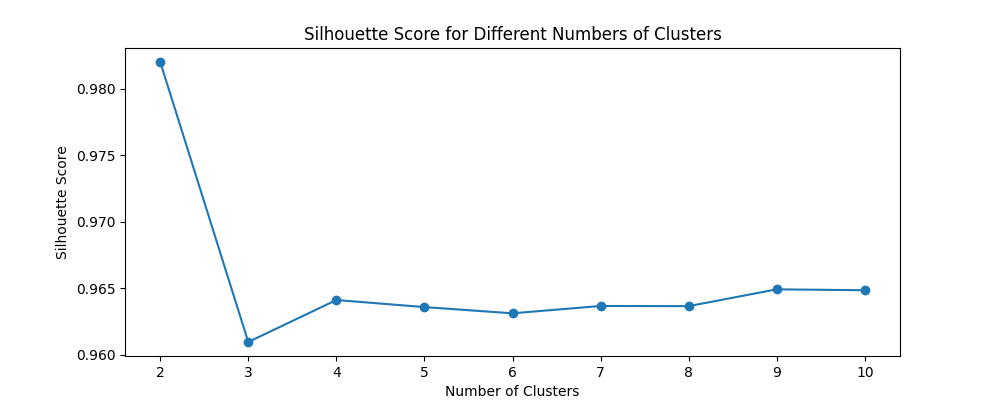

Optimal Number of Clusters: 2


In [16]:
%matplotlib ipympl

# Plot silhouette scores
plt.figure(figsize=(10, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the optimal number of clusters based on the silhouette score
# Add 2 because range starts from 2
optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2 
print(f"Optimal Number of Clusters: {optimal_num_clusters}")

Based on this graph, 2 clusters seems to be the most distinct cluster arrangement.

## 4. Running KMeans

Alright, now that we've settled on our number of clusters, it's time to run the KMeans model. We'll use two clusters, fit the model on the principal components data, and then impute the resulting clusters back into the dataframe.

In [17]:
# Run KMeans with four clusters
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
model = kmeans.fit(features_pca)

# Create labels and dataframe
clusters = pd.DataFrame(model.labels_,columns=['Cluster'])
df = pd.concat([df, clusters], axis=1)

df.head()

,CONSTITUENT_ID,MANAGED_PROSPECT,LIFETIME_GIVING,Donor,Major Donor,LIFETIME_GIFT_COUNT,FIRST_GIFT_DATE,LAST_GIFT_DATE,Years of Giving,LIFETIME_CRM_INTERACTIONS,...,FIVE_YEAR_GIVING_BAND,FIVE_YEAR_GIVING_BAND_LOW,R_Score,F_Score,M_Score,RFM_Score_Sum,RFM_Segment,Component1,Component2,Cluster
0,100730182,0,0.0,0,0,0,NA,NA,1,0,...,None,0,0,0,0,0,Non-Donor,-0.041312,-0.009994,0
1,105193921,0,0.0,0,0,0,NA,NA,1,0,...,None,0,0,0,0,0,Non-Donor,-0.041312,-0.009994,0
2,105550875,0,2000.0,1,0,1,9/28/2023,9/28/2023,1,5,...,"$1,000-$9,999",1000,5,1,5,11,Recent Donors,-0.041312,-0.009994,0
3,105941461,0,200.0,1,0,2,5/4/2021,9/29/2021,1,5,...,$1-$999,1,4,3,4,11,Recent Donors,-0.041312,-0.009994,0
4,107444925,0,1745.0,1,0,37,2/17/1978,11/9/2023,46,12,...,$1-$999,1,5,5,5,15,Champions,-0.041312,-0.009994,0


We can also pull out the cluster centroids, which are the mean values for each cluster.

In [18]:
# Get centroids
centroids = kmeans.cluster_centers_
print(centroids)

[[-4.14151573e-02 -1.66294355e-05]
 [ 9.58633116e-01  3.84920128e-04]]


In [19]:
print(df['Cluster'].value_counts())

Cluster
0    47266
1     2042
Name: count, dtype: int64


## 5. Model Evaluation

There are a number of ways we can evaluate the effectiveness of the KMeans model that we've created. One is to return to the *silhouette scores* from Section 3 - we can calculate that metric one more time for our final model to see how self-contained the data is within each cluster. We generally want a minimum score of **0.5** for the model to be usable, and a score of **0.7** or more indicates a very good fit on our data.

In [20]:
print('Silhouette Score: ' + str(silhouette_score(features_pca, kmeans.fit_predict(features_pca))))

Silhouette Score: 0.9820180964756615


A silhouette score of **0.98** indicates a very good fit!

We can also try plotting everything on a graph to see how the clusters look. We'll first bring in the functions I've used in the past for generating hover annotations - credit for these goes to this documentation: https://mplcursors.readthedocs.io/en/stable/examples/dataframe.html

In [21]:
# Function to define hover annotations
def show_hover_panel(get_text_func=None):
    cursor = mplcursors.cursor(
        hover=2,  # Transient
        annotation_kwargs=dict(
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="yellow",
                alpha=0.9,
                linewidth=0.5,
            ),
            linespacing=1.5,
            fontsize=8,
            ha="left", va="bottom",
            arrowprops=dict(arrowstyle="->", color='black')
        ),
        highlight=True,
        highlight_kwargs=dict(linewidth=2),
    )

    if get_text_func:
        cursor.connect(
            event="add",
            func=lambda sel: sel.annotation.set_text(get_text_func(sel.index)),
        )
    return cursor

In [22]:
# Function to define annotation contents
def on_add(index):
    donor = df.iloc[index]
    parts = [
        f"{donor['CONSTITUENT_ID']}",
        f"Cluster: {donor['Cluster']}",
        f"Capacity: {donor['CAPACITY_ESTIMATE']}",
        f"Correspondences: {donor['Correspondences Prior to First Gift']}",
        f"Emails Clicked: {donor['Before First Gift Video Emails Clicked']}",
        f"Videos Viewed: {donor['Before First Gift Video Views']}"
    ]
    return "\n".join(parts)

And now, the graph:

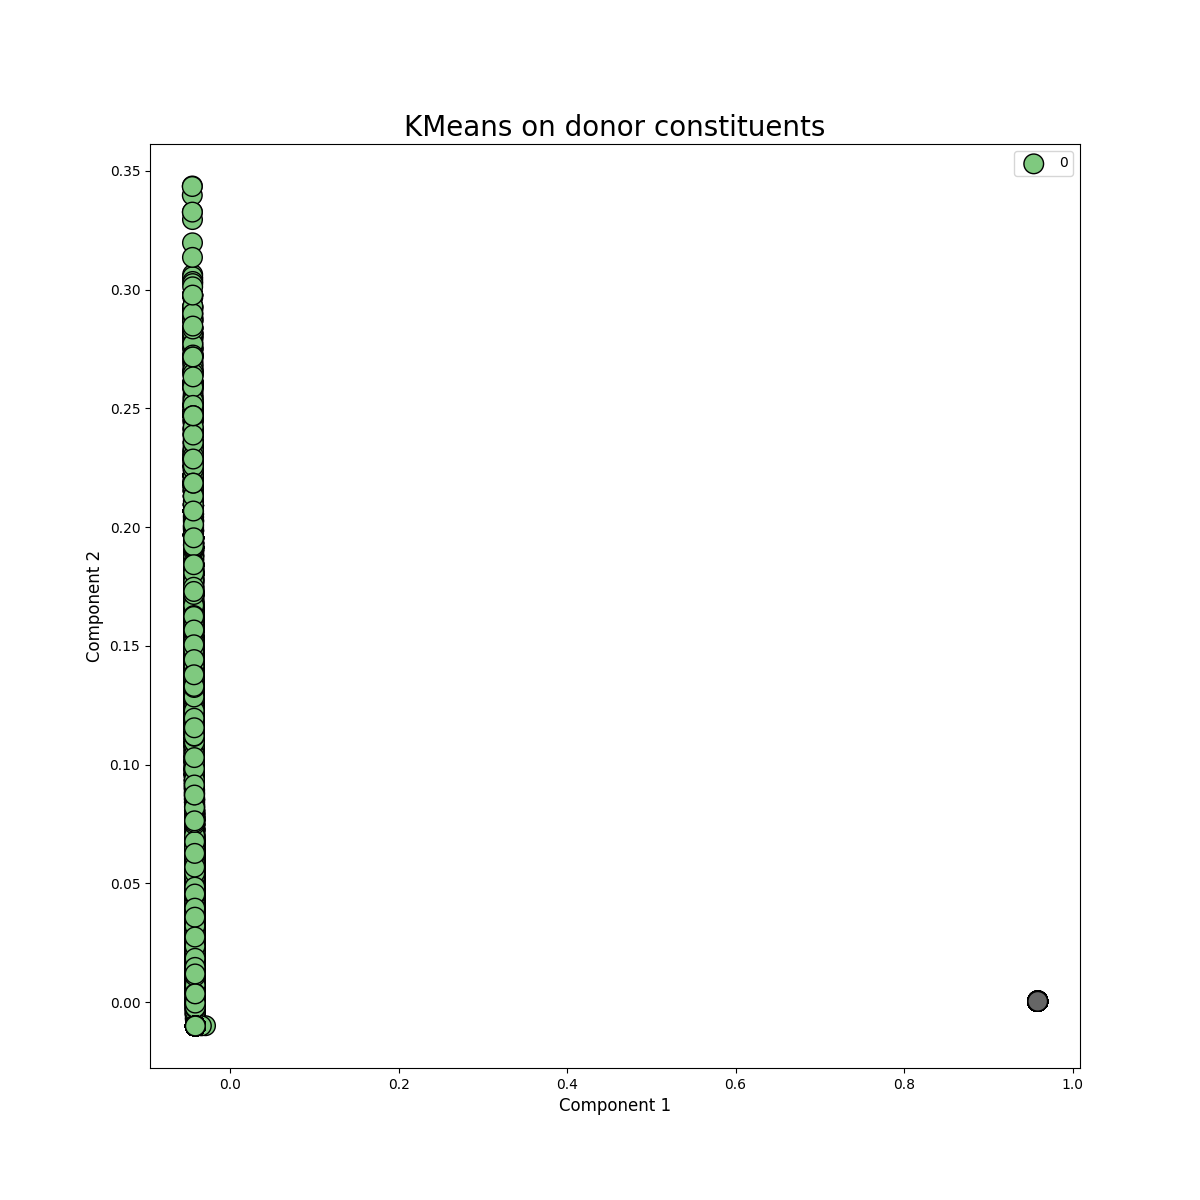

In [23]:
%matplotlib ipympl

fig = plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = 10
ax = plt.axes()
x_points = df[['Component1']]
y_points = df[['Component2']]
c = df['Cluster']
cmap = 'Accent'
s = 200
f1=ax.scatter(x_points, y_points, c=c, cmap=cmap, s=s, edgecolors='black');

ax.set_xlabel('Component 1', fontsize = 12)
ax.set_ylabel('Component 2', fontsize = 12)
ax.legend(c)

plt.title("KMeans on donor constituents",fontsize = 20)
show_hover_panel(on_add)
plt.show()

You can see how the clusters are distributed across each of our components. Hovering over each point will give you the name of the donor and some of their key statistics.

Let's take a closer look at the makeup of each individual cluster using boxplots from Python's Seaborn library. First up, **Cluster "0"**:

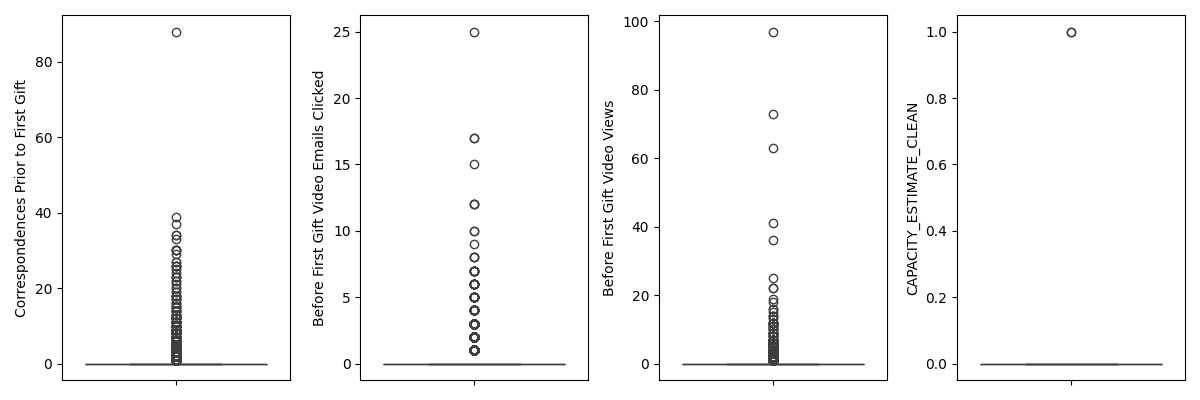

In [24]:
%matplotlib ipympl

# Filter for Cluster 0
cluster_0 = df.loc[df['Cluster'] == 0]

# Create boxplots for each feature
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i, col in enumerate(cluster_0[vars_final]):
   sns.boxplot(data=cluster_0[[col]],y=col, ax=ax[i])

# Show plots
plt.tight_layout()
plt.show()

And now, cluster 1:

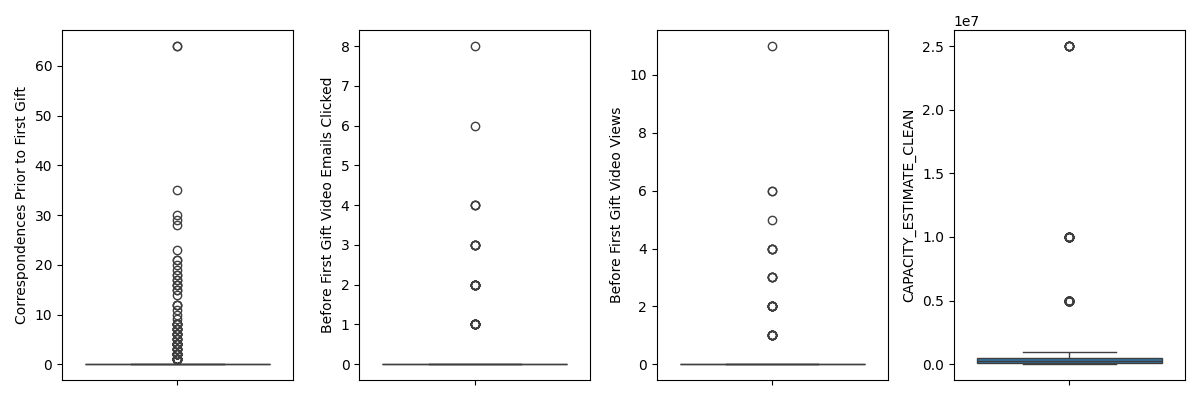

In [25]:
%matplotlib ipympl

# Filter for Cluster 0
cluster_1 = df.loc[df['Cluster'] == 1]

# Create boxplots for each feature
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i, col in enumerate(cluster_1[vars_final]):
   sns.boxplot(data=cluster_1[[col]],y=col, ax=ax[i])

# Show plots
#plt.title("Cluster 1 - 'Occasional/Recent Returnees'", fontsize = 20)
plt.tight_layout()
plt.show()